In [1]:
import pandas as pd
import numpy as np
from ln_utils import *
from transaction_simulator import *

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

### WHAT TO DO WITH INF-s???

In [3]:
experiment_id = "2019-05-28_15:00:54_k10000"
snapshots = range(8)
simulation_dir = "/mnt/idms/fberes/data/bitcoin_ln_research/simulations"

In [4]:
experiment_files = get_experiment_files(experiment_id, snapshots, simulation_dir)

In [5]:
all_infos = []
for snap_id in snapshots[:-1]:
    info, df = aggregate_samples(experiment_files, snap_id)
    all_infos.append(info)
    print(snap_id)

0
1
2
3
4
5
6


### Average correlation (over time) between cost changes and other metric

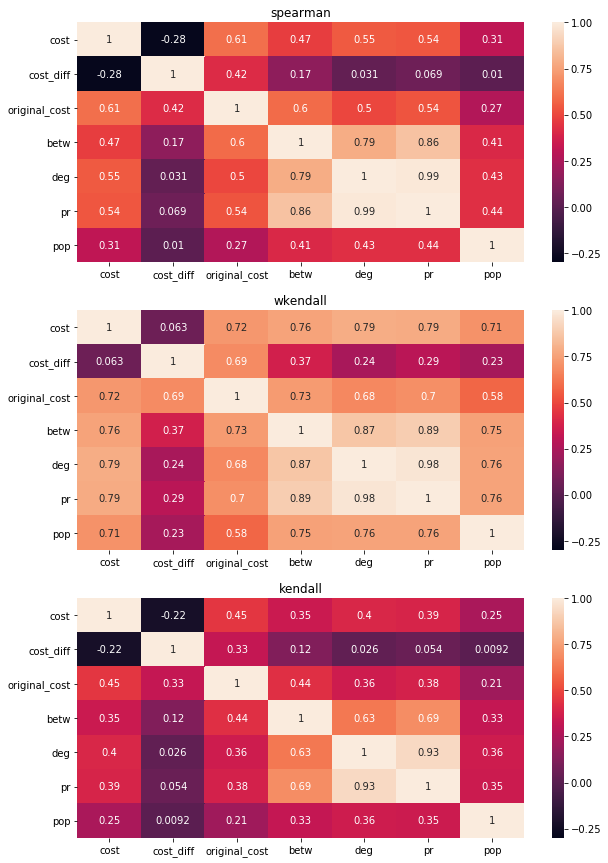

In [7]:
methods = ["spearman","wkendall","kendall"]
fig, axis = plt.subplots(len(methods), 1, figsize=(10,15))
for i, m in enumerate(methods):
    mx = corr_mx(all_infos[0].drop("removed_node", axis=1), method=m)
    for j in range(1,len(all_infos)):
        mx = np.add(mx, corr_mx(all_infos[j].drop("removed_node", axis=1), method=m))
    axis[i].set_title(m)
    sns.heatmap(mx / len(all_infos), annot=True, ax=axis[i], vmin=-0.3, vmax=1.0)

# Node analysis with 1ML background

### Average metrics of nodes

In [8]:
mean_all_info = pd.concat(all_infos, sort=True).groupby("removed_node").mean()
mean_all_info = mean_all_info.sort_values("cost_diff", ascending=False)

#### Top positive cost diff:

1. -
2. LightningTo.Me - helps with routing
3. https://meedamian.com (bitcoin evangelist)?
4. LightningPowerUsers.com - helps with routing
5. BitMEXResearch - crypto-coin ecosystem news report
6. -
7. mainnet.lightningconductor.net - helps with routing
8. moneni.com - lighting network services
9. Joltfun.com - Game shop
10. -

In [9]:
mean_all_info.head(10)

,betw,cost,cost_diff,deg,original_cost,pop,pr
removed_node,,,,,,,
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b,0.138629,0.302811,6.565291,1910.857143,6.868103,17.285714,0.018232
03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d,0.032756,0.156877,0.655730,910.857143,0.812607,16.285714,0.007428
032260c3b64b471b7eb0630b4af5d07ca94ff4e759573cbbe1bfb25845c375ed6e,0.000144,0.001245,0.442441,13.714286,0.443686,0.285714,0.000184
0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c,0.112938,0.193671,0.311658,1368.857143,0.505329,49.285714,0.015948
0395033b252c6f40e3756984162d68174e2bd8060a129c0d3462a9370471c6d28f,0.027972,0.091516,0.246616,685.428571,0.338132,32.142857,0.005421
020d41c5a32f06d7addc7378f2d4a6596358d8716a3eb5d5bbdd894a82a1fdd00c,0.006249,0.028182,0.173868,254.857143,0.202050,0.142857,0.002261
03c436af41160a355fc1ed230a64f6a64bcbd2ae50f12171d1318f9782602be601,0.006406,0.018944,0.097195,319.428571,0.116139,8.142857,0.002605
03295d2e292565743a40bd44da227a820f8730877bc3dfadebade8785bcf355258,0.005670,0.031098,0.076149,304.571429,0.107247,3.000000,0.002462
0374ecf61ed6c1208c42339f47decde2bc0c4393ac95f07827b3471e939d7eb961,0.008386,0.030031,0.075134,341.142857,0.105164,4.428571,0.002786


#### Top negative cost diff:

1. ln1.satoshilabs.com - not found server
2. https://acinq.co/ - leading companies working on Bitcoin scalability
3. LNBIG.com - (node1)
4. -
5. https://lnbig.com/ - (node2) Our nodes support greater liquidity with many nodes (pay through only one channel to us)
6. https://zigzag.io/ - Exchange Top Cryptocurrencies in seconds with low fees
7. LNBIG.com - (node3)
8. yalls.org - Read and write articles, with Lightning Network micropayments
9. -
10. tippin.me - Tip the tweets you love

In [10]:
mean_all_info.tail(10)

,betw,cost,cost_diff,deg,original_cost,pop,pr
removed_node,,,,,,,
03c2abfa93eacec04721c019644584424aab2ba4dff3ac9bdab4e9c97007491dda,0.027874,0.115752,-0.062647,742.571429,0.053105,29.571429,0.006371
03a503d8e30f2ff407096d235b5db63b4fcf3f89a653acb6f43d3fc492a7674019,0.034777,0.145298,-0.067180,672.857143,0.078118,10.428571,0.006098
03e50492eab4107a773141bb419e107bda3de3d55652e6e1a41225f06a0bbf2d56,0.013112,0.071636,-0.071199,518.285714,0.000437,8.285714,0.004434
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf,0.018916,0.074808,-0.071591,827.714286,0.003218,10.428571,0.006245
0232e20e7b68b9b673fb25f48322b151a93186bffe4550045040673797ceca43cf,0.020103,0.093761,-0.093597,659.428571,0.000164,19.000000,0.005544
0390b5d4492dc2f5318e5233ab2cebf6d48914881a33ef6a9c6bcdbb433ad986d0,0.030917,0.101171,-0.096267,940.571429,0.004904,16.285714,0.007586
02529db69fd2ebd3126fb66fafa234fc3544477a23d509fe93ed229bb0e92e4fb8,0.045904,0.302763,-0.175267,1128.285714,0.127497,13.714286,0.009470
03d37fca0656558de4fd86bbe490a38d84a46228e7ec1361801f54f9437a18d618,0.035993,0.215806,-0.209348,897.142857,0.006458,7.714286,0.007763
03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f,0.087238,0.381598,-0.320293,1422.000000,0.061305,39.714286,0.013315
